# Time series forecasting and BitPredict

In [152]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub
import shutil


## Get Data


In [153]:
# !curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [154]:
dataset = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
dataset.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [155]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [156]:
bitcoin_prices = pd.DataFrame(dataset["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


<Axes: title={'center': 'Bitcoin Price History'}, xlabel='Date', ylabel='Price'>

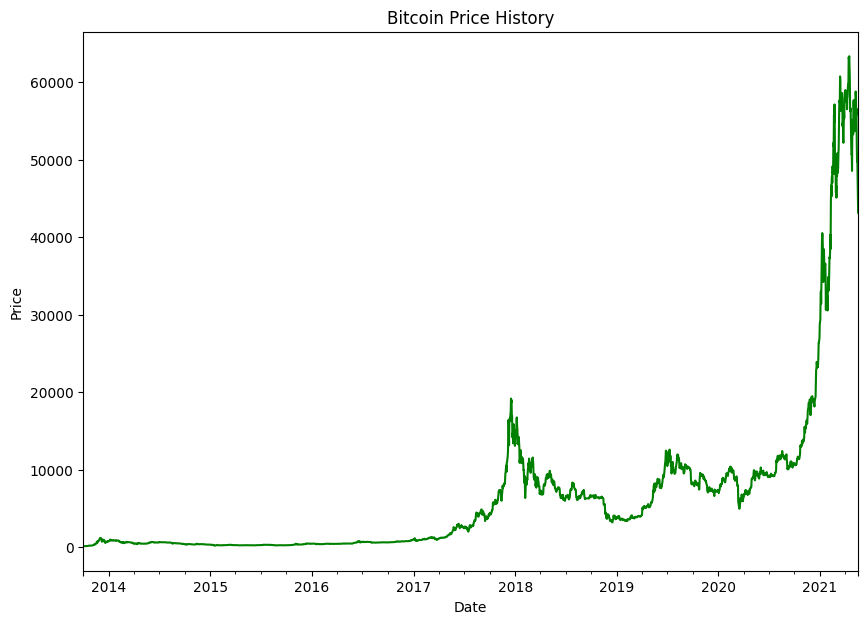

In [157]:
bitcoin_prices.plot(
    figsize=(10, 7),
    title="Bitcoin Price History",
    xlabel="Date",
    ylabel="Price",
    legend=False,
    color="green",    
)

In [158]:
split_size = int(0.8 * len(bitcoin_prices))

X_train, y_train = bitcoin_prices.index[:split_size].to_numpy(), bitcoin_prices.Price[:split_size].to_numpy()
X_test, y_test = bitcoin_prices.index[split_size:].to_numpy(), bitcoin_prices.Price[split_size:].to_numpy()

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

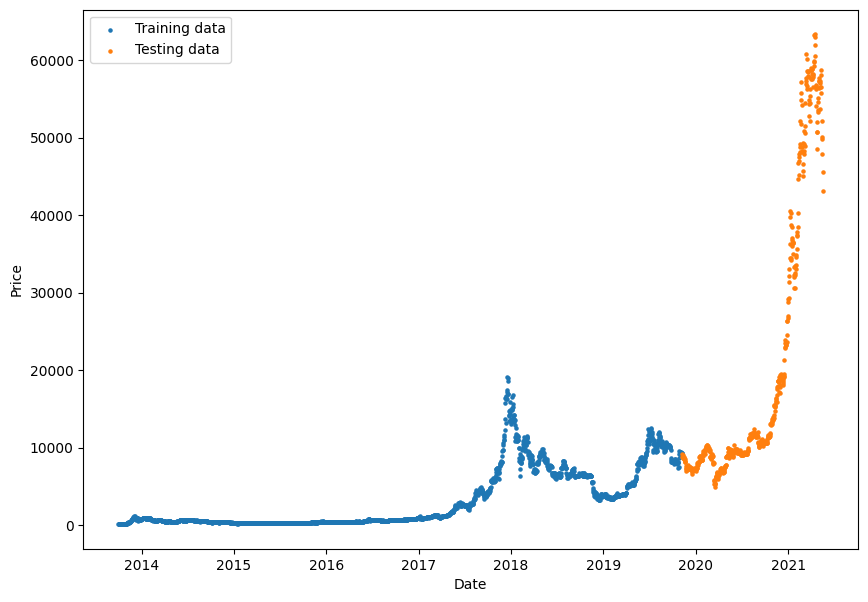

In [159]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Training data")
plt.scatter(X_test, y_test, s=5, label="Testing data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show();

In [160]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

In [161]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Returns the mean absolute scaled error between y_true and y_pred.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
    """
    Performs various evaluation comparison on y_true labels vs. y_pred labels.

    Parameters
    ----------
    y_true : array of true labels
    y_pred : array of predicted labels

    Returns a dictionary of different evaluation metrics.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    # Account for zero division
    # if mae.numpy() == 0:
    #     mase = 0
    # else:
    #     mase = mase.numpy()
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
        
    # Create dictionary of metrics
    metrics = {"mae": mae.numpy(),
               "mse": mse.numpy(),
               "rmse": rmse.numpy(),
               "mape": mape.numpy(),
               "mase": mase}
    return metrics

In [162]:
HORIZON = 1
WINDOW_SIZE = 7

In [163]:
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [164]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    # print(f"Window indexes:\n {window_indexes}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(f"Target time series:\n {x}")
    # print(f"Target time series Shape: {x.shape}")
    
    # print(f"Windowed time series:\n {windowed_array}")
    # print(f"Windowed time series Shape: {windowed_array.shape}")

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [165]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    Returns two tuples of (windows, labels) train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

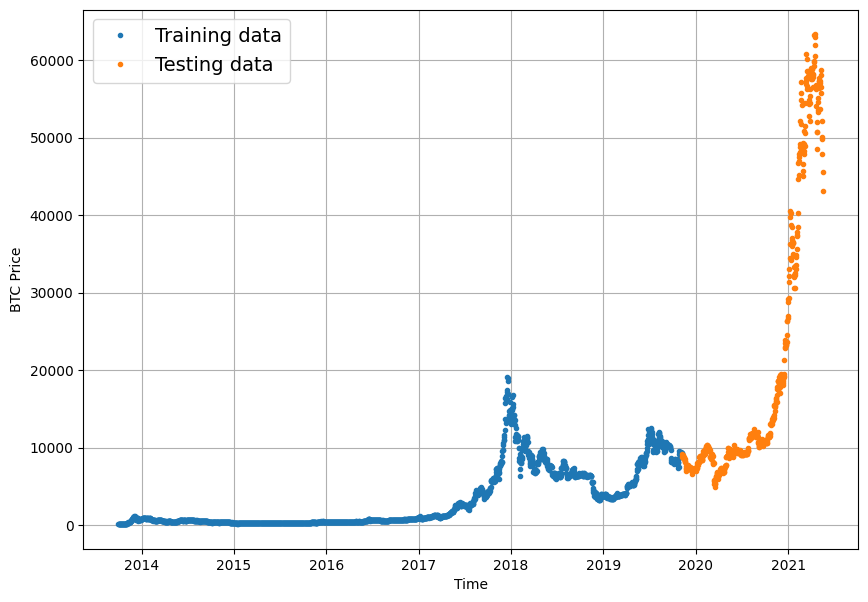

In [166]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Training data")
plot_time_series(timesteps=X_test, values=y_test, label="Testing data")


## Modeling

### Model 0: Naive forecast (baseline)

In [167]:
naive_forecast = y_test[:-1]

naive_forecast[:10], y_test[:10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

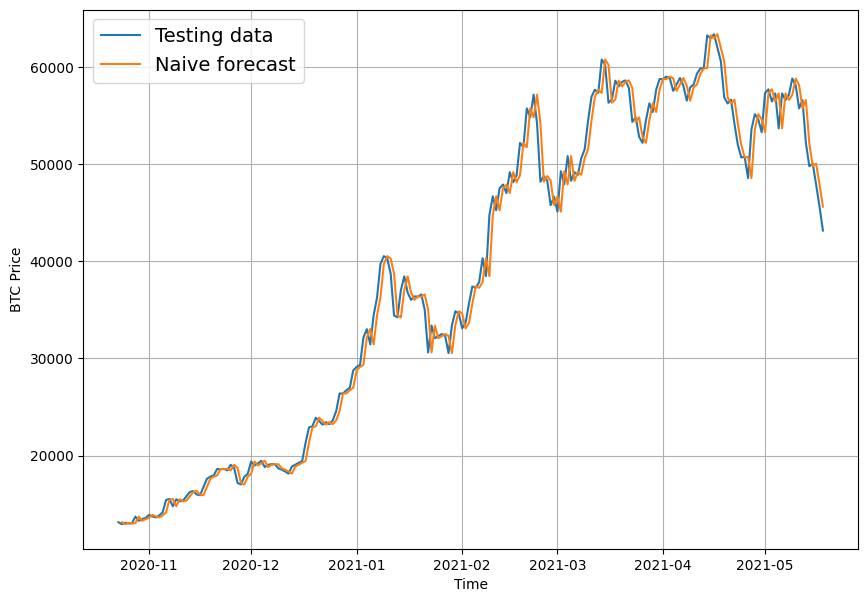

In [168]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Testing data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")


In [169]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182626>

In [170]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.1,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.99957>}

### Windowing for 1 week

In [171]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()}\nLabel: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6]
Label: 7


In [172]:
full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy())

In [173]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [174]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Making Callbacks

In [175]:
def get_callbacks(experiment_name, use_early_stopping = False, patience=3):
    if use_early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_mae",
            patience=patience,
            restore_best_weights=True,
        )
    callbacks = [
        create_tensorboard_callback(
            dir_name="bit_predict/tensorboard",
            experiment_name=experiment_name,
        ),
        create_checkpoint_callback(
            dir_name="bit_predict/checkpoint",
            experiment_name=experiment_name,
            monitor="val_mae",
            
            
        ),
    ]
    if use_early_stopping:
        callbacks.append(early_stopping)
    return callbacks

### Model 1: Dense Model (window = 7, horizon = 1)

In [176]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_1.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_1 = model_1.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_1"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_1/20240131-184818
Saving model checkpoints to: bit_predict/checkpoint/model_1/checkpoint.ckpt
Epoch 1/100
18/18 [==============================] - 1s 23ms/step - loss: 783.5582 - mae: 783.5582 - mse: 2495602.0000 - val_loss: 1229.3062 - val_mae: 1229.3062 - val_mse: 4999827.5000
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 278.7249 - mae: 278.7249 - mse: 324358.4062 - val_loss: 1259.3298 - val_mae: 1259.3298 - val_mse: 5238419.5000
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 221.2576 - mae: 221.2576 - mse: 246171.8906 - val_loss: 1308.3374 - val_mae: 1308.3374 - val_mse: 4986743.0000
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 209.3172 - mae: 209.3172 - mse: 227547.5938 - val_loss: 1161.1350 - val_mae: 1161.1350 - val_mse: 4272692.5000
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 206.0252 - mae: 206.0252 - mse:

In [177]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 574.0582 - mae: 574.0582 - mse: 1171877.1250


[574.0581665039062, 574.0581665039062, 1171877.125]

In [178]:
model_1.load_weights("bit_predict/checkpoint/model_1/checkpoint.ckpt")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 564.7738 - mae: 564.7738 - mse: 1161542.7500


[564.7738037109375, 564.7738037109375, 1161542.75]

In [179]:
model_1_results1 = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_1.predict(test_windows)))
model_1_results1

18/18 [==============================] - 0s 3ms/step


{'mae': 564.77386,
 'mse': 1161542.9,
 'rmse': 1077.749,
 'mape': 2.5159662,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.99215114>}

18/18 [==============================] - 0s 1ms/step


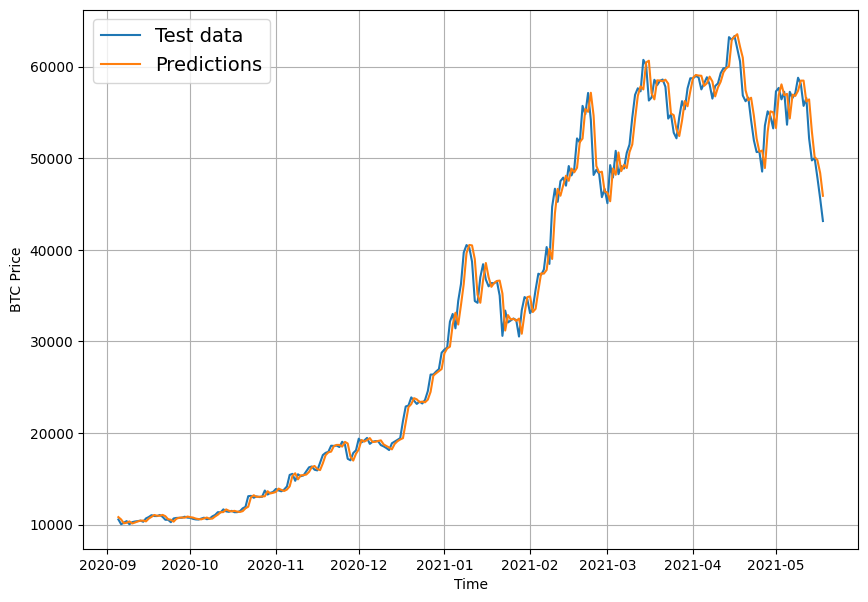

In [180]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_1.predict(test_windows)[:, 0], start=offset, format="-", label="Predictions")


### Model 2: Dense (window = 30, horizon = 1)

In [181]:
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [182]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [183]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_2.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_2 = model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_2"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_2/20240131-184834
Saving model checkpoints to: bit_predict/checkpoint/model_2/checkpoint.ckpt


In [184]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 8ms/step - loss: 726.1545 - mae: 726.1545 - mse: 1569213.8750


[726.1544799804688, 726.1544799804688, 1569213.875]

In [185]:
model_2.load_weights("bit_predict/checkpoint/model_2/checkpoint.ckpt")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 592.8228 - mae: 592.8228 - mse: 1204443.1250


[592.8228149414062, 592.8228149414062, 1204443.125]

In [186]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_2.predict(test_windows)))
model_2_results

18/18 [==============================] - 0s 1ms/step


{'mae': 592.82294,
 'mse': 1204443.2,
 'rmse': 1097.4713,
 'mape': 2.6793947,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=1.0362604>}

18/18 [==============================] - 0s 1ms/step


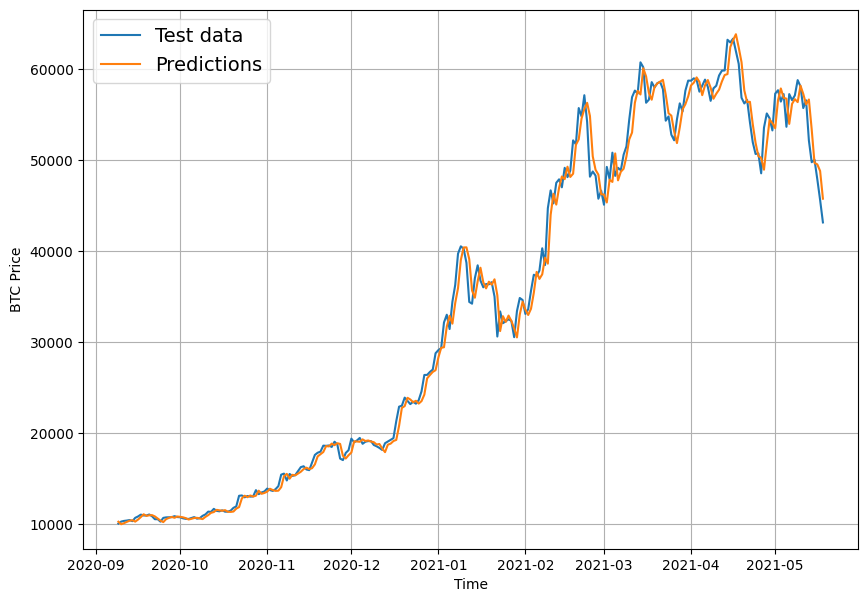

In [187]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_2.predict(test_windows)[:, 0], start=offset, format="-", label="Predictions")

### Model 3: Dense (window = 30, horizon = 7)

In [188]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [189]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [190]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_3.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_3 = model_3.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_3"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_3/20240131-184847
Saving model checkpoints to: bit_predict/checkpoint/model_3/checkpoint.ckpt


In [191]:
model_3.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 6ms/step - loss: 1322.4768 - mae: 1322.4768 - mse: 5698441.0000


[1322.476806640625, 1322.476806640625, 5698441.0]

In [192]:
model_3.load_weights("bit_predict/checkpoint/model_3/checkpoint.ckpt")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1232.4194 - mae: 1232.4194 - mse: 5238623.0000


[1232.41943359375, 1232.41943359375, 5238623.0]

In [193]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_3.predict(test_windows)))
model_3_results


18/18 [==============================] - 0s 1ms/step


{'mae': 1232.4194,
 'mse': 5238623.5,
 'rmse': 1428.5488,
 'mape': 5.704684,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=2.1930215>}

18/18 [==============================] - 0s 2ms/step


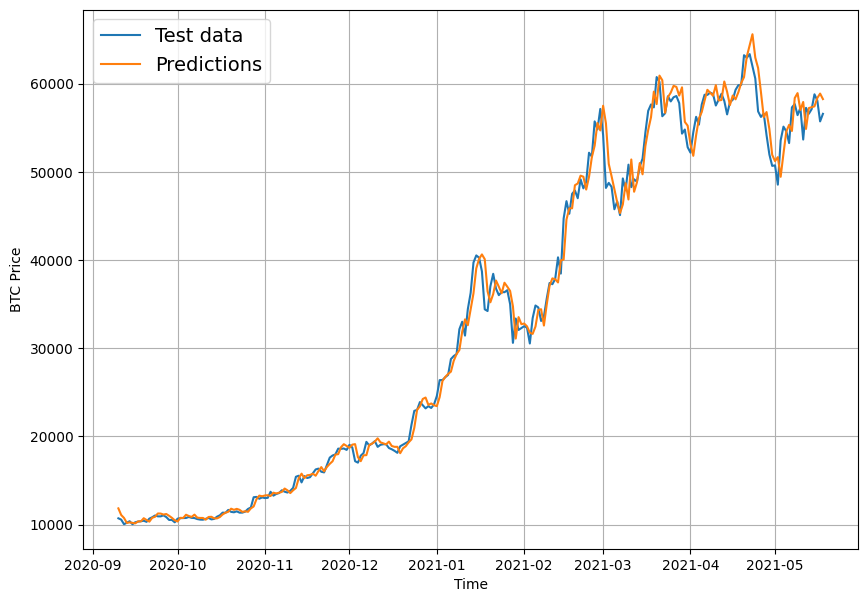

In [194]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_3.predict(test_windows)[:, 0], start=offset, format="-", label="Predictions")

18/18 [==============================] - 0s 1ms/step


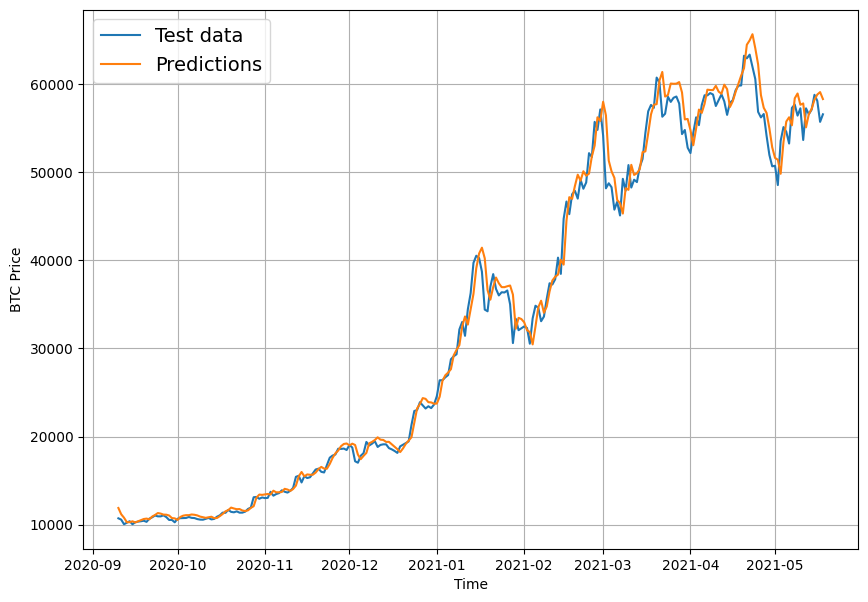

In [195]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], format='-', start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_labels):], values=tf.reduce_mean(model_3.predict(test_windows), axis=1), start=offset, format="-", label="Predictions")

### Model 4: Conv1D

In [196]:
HORIZON = 1
WINDOW_SIZE = 7

In [197]:
full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [198]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [199]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [200]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [201]:
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")


Original shape: (7,)
Expanded shape: (7, 1)


In [202]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_4.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_4 = model_4.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_4"),
)
model_4.evaluate(test_windows, test_labels)

Saving TensorBoard log files to: bit_predict/tensorboard/model_4/20240131-184900
Saving model checkpoints to: bit_predict/checkpoint/model_4/checkpoint.ckpt
Epoch 1/100
18/18 [==============================] - 1s 30ms/step - loss: 1514.3004 - mae: 1514.3004 - mse: 7252419.5000 - val_loss: 1199.9874 - val_mae: 1199.9874 - val_mse: 4699689.5000
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 344.0077 - mae: 344.0077 - mse: 473426.3750 - val_loss: 1843.9794 - val_mae: 1843.9794 - val_mse: 8142819.5000
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 237.2035 - mae: 237.2035 - mse: 270678.8438 - val_loss: 1161.8197 - val_mae: 1161.8197 - val_mse: 4156916.0000
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 204.9075 - mae: 204.9075 - mse: 208923.3594 - val_loss: 1086.3914 - val_mae: 1086.3914 - val_mse: 3940325.2500
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 195.3502 - mae: 195.3502 - 

[668.5245361328125, 668.5245361328125, 1389442.5]

In [203]:
model_4.load_weights("bit_predict/checkpoint/model_4/checkpoint.ckpt")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 568.1949 - mae: 568.1949 - mse: 1179962.2500


[568.1949462890625, 568.1949462890625, 1179962.25]

In [204]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_4.predict(test_windows)))
model_4_results

18/18 [==============================] - 0s 3ms/step


{'mae': 568.19495,
 'mse': 1179962.2,
 'rmse': 1086.2606,
 'mape': 2.54377,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.998161>}

### Model 5: LSTM

In [205]:
tf.random.set_seed(42)

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
x = expand_dims_layer(inputs)
x = tf.keras.layers.LSTM(128, activation='relu')(x)
x = tf.keras.layers.Dense(HORIZON, activation="linear")(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=x, name="model_5_conv1d")

model_5.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_5 = model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=get_callbacks("model_5"),
)

model_5.evaluate(test_windows, test_labels)

Saving TensorBoard log files to: bit_predict/tensorboard/model_5/20240131-184919
Saving model checkpoints to: bit_predict/checkpoint/model_5/checkpoint.ckpt
Epoch 1/100
18/18 [==============================] - 2s 55ms/step - loss: 1974.4508 - mae: 1974.4508 - mse: 10144267.0000 - val_loss: 6431.6348 - val_mae: 6431.6348 - val_mse: 75526616.0000
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - loss: 424.1508 - mae: 424.1508 - mse: 685127.6875 - val_loss: 1985.4482 - val_mae: 1985.4482 - val_mse: 10509139.0000
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 244.4386 - mae: 244.4386 - mse: 254399.1719 - val_loss: 1382.6779 - val_mae: 1382.6779 - val_mse: 5125531.5000
Epoch 4/100
18/18 [==============================] - 0s 16ms/step - loss: 200.2001 - mae: 200.2001 - mse: 205902.5781 - val_loss: 1133.1056 - val_mae: 1133.1056 - val_mse: 4044382.7500
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 195.8931 - mae: 195.893

[633.6085815429688, 633.6085815429688, 1352181.25]

In [206]:
model_5.load_weights("bit_predict/checkpoint/model_5/checkpoint.ckpt")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 583.9094 - mae: 583.9094 - mse: 1224694.8750


[583.909423828125, 583.909423828125, 1224694.875]

In [207]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=tf.squeeze(model_5.predict(test_windows)))
model_5_results

18/18 [==============================] - 0s 7ms/step


{'mae': 583.9094,
 'mse': 1224695.0,
 'rmse': 1106.6594,
 'mape': 2.6355433,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=1.025767>}

### Model 6: Multivariate time series forecasting

In [208]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")


In [209]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [210]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None


bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

<Axes: xlabel='Date'>

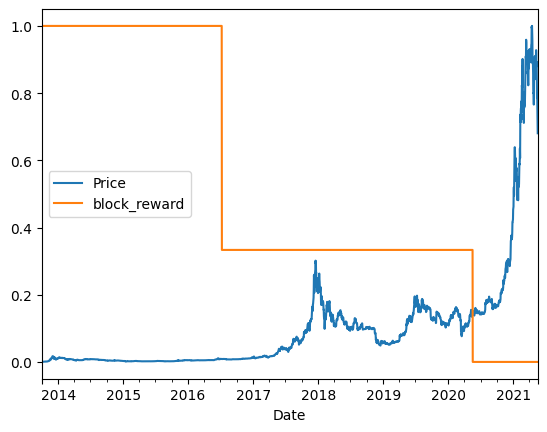

In [211]:
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot()

#### Making windowed data with pandas (Multivariate)

In [212]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
    
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [213]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [214]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [215]:
split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [216]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
])

model_6.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae", "mse"],
)

history_6 = model_6.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=get_callbacks("model_6"),
)

Saving TensorBoard log files to: bit_predict/tensorboard/model_6/20240131-184950
Saving model checkpoints to: bit_predict/checkpoint/model_6/checkpoint.ckpt
Epoch 1/100
18/18 [==============================] - 1s 50ms/step - loss: 825.3787 - mae: 825.3787 - mse: 2671646.5000 - val_loss: 1583.6971 - val_mae: 1583.6971 - val_mse: 7441901.5000
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 253.8144 - mae: 253.8144 - mse: 283209.7500 - val_loss: 1214.5164 - val_mae: 1214.5164 - val_mse: 4843098.5000
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 201.1872 - mae: 201.1872 - mse: 209734.4531 - val_loss: 1168.2904 - val_mae: 1168.2904 - val_mse: 4083616.2500
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 191.0390 - mae: 191.0390 - mse: 195171.1406 - val_loss: 1090.5912 - val_mae: 1090.5912 - val_mse: 3694233.2500
Epoch 5/100
18/18 [==============================] - 0s 14ms/step - loss: 185.6665 - mae: 185.6665 - mse

In [217]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 8ms/step - loss: 748.3936 - mae: 748.3936 - mse: 1610512.0000


[748.3936157226562, 748.3936157226562, 1610512.0]

In [218]:
model_6.load_weights("bit_predict/checkpoint/model_6/checkpoint.ckpt")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 566.9649 - mae: 566.9649 - mse: 1163647.1250


[566.9649047851562, 566.9649047851562, 1163647.125]

In [219]:
model_6_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(model_6.predict(X_test)))
model_6_results

18/18 [==============================] - 0s 1ms/step


{'mae': 566.9649,
 'mse': 1163647.1,
 'rmse': 1078.7247,
 'mape': 2.5168254,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.9960002>}

### Model 7: N-Beats Model

In [220]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [221]:
dummy_nbeat_block = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE + HORIZON,
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4,
)

In [222]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [223]:
backcast, forecast = dummy_nbeat_block(dummy_inputs)

backcast, forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[-0.5400876 , -0.548064  ,  0.2901272 ,  0.34172392,  0.16080895,
         -0.36795643, -0.22119305]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.38447413]], dtype=float32)>)

#### Making data with `tf.data`

In [224]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback
bitcoin_prices.head()


,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [225]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()


,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [226]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(2224, 2224, 556, 556)

In [227]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [228]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE


(7, 8)

In [229]:
from keras import layers


In [133]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")


Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [134]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.average([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 1/5000


2024-01-31 16:56:41.268272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 32s 6s/step - loss: 159880.4531 - mae: 159880.4531 - mse: 311537401856.0000 - val_loss: 3839982848.0000 - val_mae: 3839982848.0000 - val_mse: 26054458540338184192.0000 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 2s 696ms/step - loss: 216490737664.0000 - mae: 216490737664.0000 - mse: 160457327986101152907264.0000 - val_loss: 397905056.0000 - val_mae: 397905056.0000 - val_mse: 279738572972490752.0000 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 2s 663ms/step - loss: 4129869.2500 - mae: 4129869.2500 - mse: 39882017734656.0000 - val_loss: 1224351.5000 - val_mae: 1224351.5000 - val_mse: 2647703158784.0000 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 1s 177ms/step - loss: 3698448.7500 - mae: 3698448.7500 - mse: 45338467500032.0000 - val_loss: 7381749248.0000 - val_mae: 7381749248.0000 - val_mse: 96221983294026153984.0000 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 1s 518ms

In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 47ms/step - loss: 4590218.0000


4590218.0

In [ ]:
model_7_results = evaluate_preds(y_true=y_test, y_pred=tf.squeeze(model_7.predict(test_dataset)))
model_7_results

1/1 [==============================] - 1s 960ms/step


{'mae': 4590218.0,
 'mse': 37292714000000.0,
 'rmse': 6106776.0,
 'mape': 23007.531,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=8063.7407>}

In [230]:
model_1_results1

{'mae': 564.77386,
 'mse': 1161542.9,
 'rmse': 1077.749,
 'mape': 2.5159662,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.99215114>}

In [83]:
tf.keras.utils.plot_model(model_7)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Model 8: Ensemble of N-BEATS models trained on different windows

In [231]:
def get_ensemble_model(
    horizon=HORIZON,
    train_data=train_dataset,
    test_data=test_dataset,
    num_iter=10,
    num_epochs=1000,
    loss_fns=["mae", "mse", "mape"],
):
    """
    Returns an ensemble model trained on train_data and evaluated on test_data.
    """

    ensemble_models = []

    for i in range(num_iter):
        for loss_function in loss_fns:
            print(
                f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i+1}"
            )

            model = tf.keras.Sequential(
                [
                    tf.keras.layers.Dense(
                        128, activation="relu", kernel_initializer="he_normal"
                    ),
                    tf.keras.layers.Dense(
                        128, activation="relu", kernel_initializer="he_normal"
                    ),
                    tf.keras.layers.Dense(horizon, activation="linear"),
                ]
            )

            model.compile(
                loss=loss_function,
                optimizer=tf.keras.optimizers.legacy.Adam(0.001),
                metrics=["mae", "mse"],
            )

            history = model.fit(
                train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss", patience=200, restore_best_weights=True
                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                        monitor="val_loss", patience=100, verbose=1
                    ),
                ],
            )
            
            ensemble_models.append(model)
            
    return ensemble_models

In [232]:
ensemble_models = get_ensemble_model(num_iter=5)


Optimizing model by reducing: mae for 1000 epochs, model number: 1


KeyboardInterrupt: 

In [ ]:
def make_ensemble_preds(models, data):
    """
    Returns predictions from a list of models on a given dataset.
    """
    ensemble_preds = []
    for model in models:
        preds = model.predict(data)
        ensemble_preds.append(tf.squeeze(preds))
    return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 23ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8857.9  ,  8824.596,  9069.49 , ..., 50161.77 , 48234.316,
        45733.438],
       [ 8846.915,  8818.436,  9063.015, ..., 49795.85 , 48218.9  ,
        45816.086],
       [ 8839.668,  8815.498,  9068.437, ..., 49894.223, 48027.574,
        45725.293],
       ...,
       [ 8849.245,  8874.976,  9035.426, ..., 49995.082, 47811.895,
        45842.137],
       [ 8822.803,  8848.818,  9068.264, ..., 50012.312, 47871.64 ,
        46034.734],
       [ 8835.923,  8819.574,  9076.217, ..., 50032.668, 48004.586,
        45778.77 ]], dtype=float32)>

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)
ensemble_results

{'mae': 578.4734,
 'mse': 1192323.2,
 'rmse': 1091.4408,
 'mape': 2.5835004,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=1.0162175>}

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8856.912 ,  8830.842 ,  9071.917 ,  8740.0625,  8773.29  ,
        8752.18  ,  8704.606 ,  8510.065 ,  8495.971 ,  8548.477 ,
        8237.194 ,  8148.7993,  8086.99  ,  7667.5054,  7302.136 ,
        7315.164 ,  7066.4287,  7205.196 ,  7123.269 ,  7526.061 ,
        7376.5786,  7748.682 ,  7541.9253,  7449.5107,  7342.724 ,
        7352.5244,  7226.488 ,  7396.408 ,  7505.4814,  7545.5796,
        7557.5933,  7371.6235,  7278.298 ,  7215.7773,  7209.1807,
        7237.9272,  7103.619 ,  7131.201 ,  6906.697 ,  6633.76  ,
        7382.0464,  7138.333 ,  7178.8237,  7255.0894,  7301.8086,
        7176.6494,  7244.816 ,  7233.5522,  7201.37  ,  7234.6094,
        7322.449 ,  7391.899 ,  7271.2505,  7208.882 ,  7193.949 ,
        6989.257 ,  7286.821 ,  7323.916 ,  7370.339 ,  7688.0454,
        8036.55  ,  8079.3706,  7844.345 ,  8115.8594,  8096.72  ,
        8174.359 ,  8112.841 ,  8731.302 ,  8823.924 ,  8752.981 ,
        8927.9

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

array([ 8835.923 ,  8818.436 ,  9069.49  ,  8735.265 ,  8763.724 ,
        8748.288 ,  8688.357 ,  8509.614 ,  8479.853 ,  8545.366 ,
        8231.545 ,  8136.3984,  8078.8755,  7652.2344,  7290.68  ,
        7302.1133,  7061.589 ,  7205.1963,  7129.4937,  7518.428 ,
        7393.322 ,  7736.5786,  7553.64  ,  7426.8853,  7344.014 ,
        7337.726 ,  7228.123 ,  7393.8486,  7507.68  ,  7543.338 ,
        7555.0923,  7358.1587,  7267.295 ,  7211.344 ,  7203.124 ,
        7240.2397,  7096.7134,  7122.2646,  6899.1113,  6617.7725,
        7391.814 ,  7158.7373,  7173.846 ,  7263.6357,  7276.3184,
        7187.0796,  7237.6084,  7228.0244,  7196.694 ,  7230.059 ,
        7318.453 ,  7391.689 ,  7266.574 ,  7198.7305,  7186.8413,
        6982.795 ,  7286.119 ,  7334.073 ,  7368.369 ,  7699.3184,
        8032.7256,  8087.97  ,  7831.738 ,  8099.755 ,  8100.4707,
        8170.7104,  8115.7793,  8723.482 ,  8833.884 ,  8749.361 ,
        8927.961 ,  8965.723 ,  8683.447 ,  8665.904 ,  8718.4

In [ ]:
ensemble_results_mean = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)
ensemble_results_mean

{'mae': 568.1214,
 'mse': 1162936.2,
 'rmse': 1078.3953,
 'mape': 2.532016,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.99803185>}

In [ ]:
ensemble_results_median = evaluate_preds(y_true=y_test, y_pred=ensemble_median)
ensemble_results_median

{'mae': 565.4794,
 'mse': 1155912.1,
 'rmse': 1075.1335,
 'mape': 2.512124,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=0.9933905>}

In [ ]:
def get_upper_lower(preds):
    # return np.percentile(preds, 95), np.percentile(preds, 5)
    std = tf.math.reduce_std(preds, axis=0)
    
    interval = 1.96 * std
    
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    
    return lower, upper

In [ ]:
ensemble_lower, ensemble_upper = get_upper_lower(ensemble_preds)
ensemble_lower, ensemble_upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8742.897 ,  8758.199 ,  9030.001 ,  8668.375 ,  8704.309 ,
         8637.623 ,  8604.373 ,  8480.44  ,  8393.984 ,  8510.546 ,
         8175.2993,  8075.103 ,  8021.403 ,  7579.552 ,  7245.966 ,
         7241.0156,  7006.8276,  7164.6895,  7014.995 ,  7445.7515,
         7288.082 ,  7638.212 ,  7461.274 ,  7304.166 ,  7305.4087,
         7258.5566,  7198.492 ,  7350.7715,  7448.987 ,  7495.32  ,
         7512.434 ,  7282.8267,  7210.5225,  7181.1445,  7166.7773,
         7212.161 ,  7035.1978,  7073.049 ,  6847.1284,  6551.6226,
         7301.62  ,  6988.924 ,  7059.2695,  7138.8677,  7129.7344,
         7085.5977,  7170.758 ,  7177.6855,  7167.831 ,  7192.362 ,
         7271.72  ,  7359.1777,  7218.655 ,  7142.184 ,  7146.5884,
         6935.8936,  7237.516 ,  7246.265 ,  7303.005 ,  7633.815 ,
         7956.6313,  8033.9263,  7772.1636,  8011.0474,  8043.409 ,
         8106.439 ,  8058.593 ,  8642.365 ,  8735.427 ,  8657.102 ,

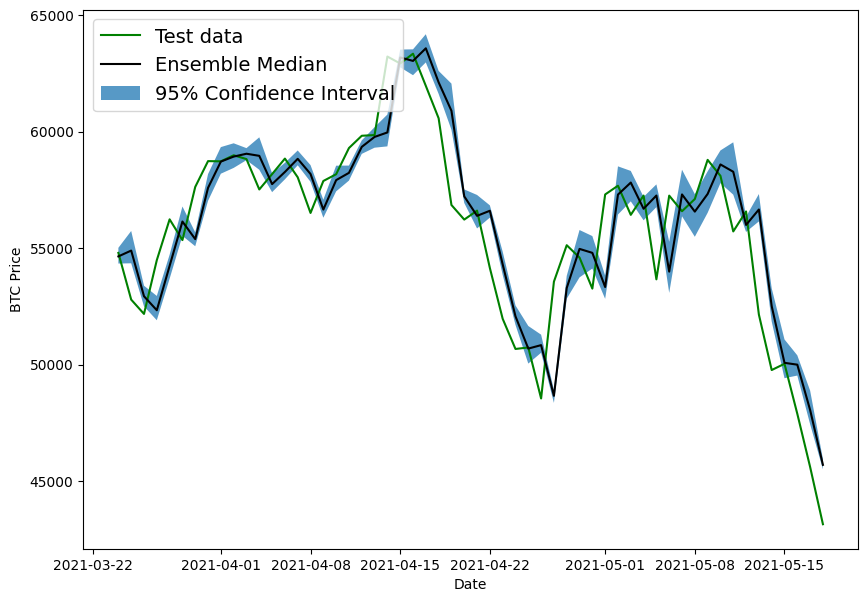

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], ensemble_lower[offset:], ensemble_upper[offset:], alpha=0.75, label="95% Confidence Interval")
plt.legend(fontsize=14, loc="upper left")

### Model 9: Train model on full historic data and predict future

In [ ]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

X_all.shape, y_all.shape

((2780, 7), (2780,))

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

dataset_all = dataset_all.batch(1024).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
model_9 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(HORIZON, activation="linear"),
    ]
)

model_9.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
)

history_9 = model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=100,
            restore_best_weights=True,
        ),
    ],
)

In [ ]:
model_9.evaluate(dataset_all)

3/3 [==============================] - 0s 8ms/step - loss: 226.8844


226.8843536376953

In [ ]:
model_9_results = evaluate_preds(y_true=y_all, y_pred=tf.squeeze(model_9.predict(dataset_all)))
model_9_results

3/3 [==============================] - 0s 3ms/step


{'mae': 226.88435,
 'mse': 356533.12,
 'rmse': 597.10394,
 'mape': 3.2262986,
 'mase': <tf.Tensor: shape=(), dtype=float32, numpy=1.145005>}

In [ ]:
INTO_FUTURE = 14

def make_future_forecast(values, model, window_size=WINDOW_SIZE, into_future=INTO_FUTURE) -> list:
    """
    Makes forecasts into the future with a given model.
    """
    future_forecast = []
    last_window = values[-window_size:]
    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred)[-window_size:]
    return future_forecast

In [ ]:
future_forecast = make_future_forecast(values=y_all, model=model_9)
future_forecast

1/1 [==============================] - 0s 10ms/step


[55597.156,
 52936.215,
 49731.93,
 47080.305,
 47568.652,
 47203.04,
 49230.246,
 54855.043,
 52038.254,
 48267.62,
 46653.645,
 48785.895,
 50174.156,
 52215.527]

In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


### Model 10: Turkey Problem

In [ ]:
...

Ellipsis

### Comparing Models

In [237]:
model_results = pd.DataFrame(
    {
        "naive_model": naive_results,
        "model_1": model_1_results1,
        "model_2": model_2_results,
        # "model_3": model_3_results,
        "model_4": model_4_results,
        "model_5": model_5_results,
        "model_6": model_6_results,
        # "model_7": model_7_results,
        "ensemble_results": ensemble_results,
        "ensemble_results_mean": ensemble_results_mean,
        "ensemble_results_median": ensemble_results_median,
    }
)

model_results = model_results.T
model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.125,1071.236206,2.516525,"tf.Tensor(0.99957, shape=(), dtype=float32)"
model_1,564.773865,1161542.875,1077.749023,2.515966,"tf.Tensor(0.99215114, shape=(), dtype=float32)"
model_2,592.822937,1204443.25,1097.471313,2.679395,"tf.Tensor(1.0362604, shape=(), dtype=float32)"
model_4,568.194946,1179962.25,1086.26062,2.54377,"tf.Tensor(0.998161, shape=(), dtype=float32)"
model_5,583.909424,1224695.0,1106.659424,2.635543,"tf.Tensor(1.025767, shape=(), dtype=float32)"
model_6,566.964905,1163647.125,1078.724731,2.516825,"tf.Tensor(0.9960002, shape=(), dtype=float32)"
ensemble_results,578.473389,1192323.25,1091.440796,2.5835,"tf.Tensor(1.0162175, shape=(), dtype=float32)"
ensemble_results_mean,568.121399,1162936.25,1078.395264,2.532016,"tf.Tensor(0.99803185, shape=(), dtype=float32)"
ensemble_results_median,565.47937,1155912.125,1075.133545,2.512124,"tf.Tensor(0.9933905, shape=(), dtype=float32)"


<Axes: >

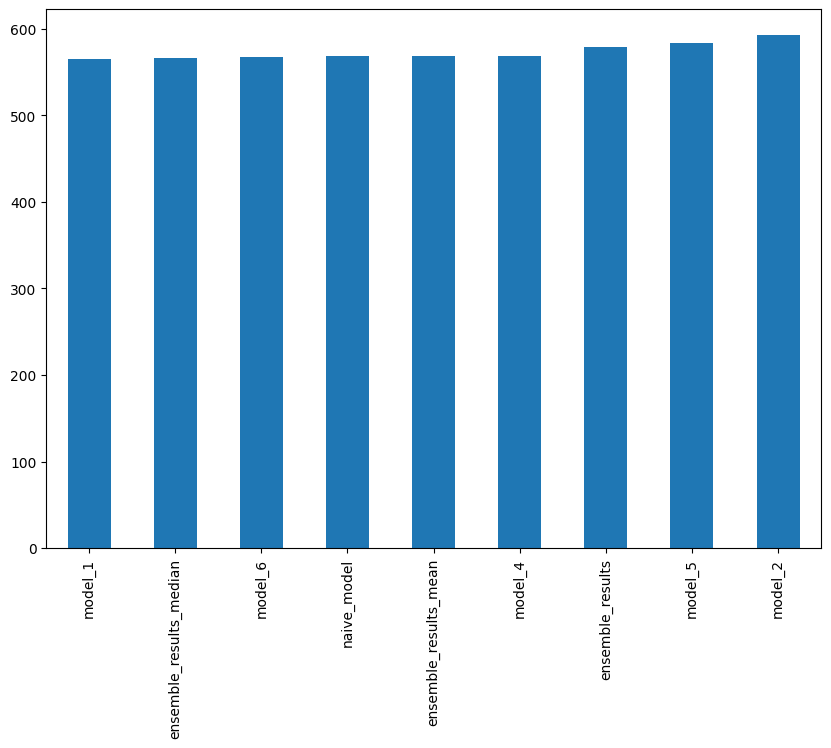

In [238]:
model_results["mae"].sort_values().plot(kind="bar", figsize=(10, 7))